# NCAA ML Competition - Women's 2018
## W207 Final Project
## Julia Buffinton, Charlene Chen, Arvindh Ganesan, Prashant Kumar Sahay
### Due: 4/17/18

## Import Relevant Libraries

In [66]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools as it

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import svm

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import log_loss
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score

## Load regular season data

In [25]:
# Load the data
data_dir = './WStage2DataFiles/'
df_seeds = pd.read_csv(data_dir + 'WNCAATourneySeeds.csv')
df_tour_compact = pd.read_csv(data_dir + 'WNCAATourneyCompactResults.csv')
df_tour_detail = pd.read_csv(data_dir + 'WNCAATourneyDetailedResults.csv')
df_reg_compact = pd.read_csv(data_dir + 'WRegularSeasonCompactResults.csv')
df_reg_detail = pd.read_csv(data_dir + 'WRegularSeasonDetailedResults.csv')
df_teams = pd.read_csv(data_dir + 'WTeams.csv')
df_teams_leagues = pd.merge(left=df_teams, right=pd.read_csv(data_dir + 'WLeagues.csv'), how='left', on=['TeamName'])
df_tour_18 = pd.read_csv('NCAA_Result_2018_sep.csv')

## Get just numeric seeds - we aren't interested in region

In [26]:
# get just integer value of seed (exclude region information)
def seed_to_int(seed):
    #Get just the digits from the seeding. Return as int
    s_int = int(seed[1:3])
    return s_int
df_seeds['SeedInt'] = df_seeds.Seed.apply(seed_to_int)
df_seeds.drop(labels=['Seed'], inplace=True, axis=1) # This is the string label

## Load the league that each team belongs to

In [27]:
df_winning_team_leagues = df_teams_leagues.rename(columns={'TeamID' : 'WTeamID', 'LeagueName' : 'WLeagueName'}).drop('TeamName',1)
df_winning_team_leagues.head()

,WTeamID,WLeagueName
0,3101,Southland
1,3102,MWC
2,3103,MAC
3,3104,SEC
4,3105,SWAC


## Load and bin league performance (to dampen the effect of small variations)

In [28]:
## Bin league performance into 10 bins
df_league_perf = pd.read_pickle('league_performance')
df_league_perf['Leaguebin'] = pd.cut(df_league_perf['PctWins mean'], 24, labels=False)

df_league_perf = df_league_perf[['LeagueName', 'Leaguebin']]
df_team_league_perf = pd.merge(left=df_teams_leagues, right=df_league_perf, how='left', on=['LeagueName'])

df_team_league_perf = df_team_league_perf[['TeamID', 'Leaguebin']]
df_team_league_perf.head()

,TeamID,Leaguebin
0,3101,1.0
1,3102,7.0
2,3103,2.0
3,3104,23.0
4,3105,0.0


In [29]:
## Inject winning and losing teams' leaugues into df
# Total of 36 columns
df_reg_detail = pd.merge(left=df_reg_detail, right=df_winning_team_leagues, how='left', on=['WTeamID'])

df_losing_team_leagues = df_winning_team_leagues.rename(columns={'WTeamID': 'LTeamID', 'WLeagueName': 'LLeagueName'})
df_reg_detail = pd.merge(left=df_reg_detail, right=df_losing_team_leagues, how='left', on=['LTeamID'])
df_reg_detail.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF,WLeagueName,LLeagueName
0,2010,11,3103,63,3237,49,H,0,23,54,...,10,11,27,11,23,7,6,19,MAC,Horizon
1,2010,11,3104,73,3399,68,N,0,26,62,...,27,14,26,7,20,4,2,27,SEC,OVC
2,2010,11,3110,71,3224,59,A,0,29,62,...,23,17,23,8,15,6,0,15,Patriot,MEAC
3,2010,11,3111,63,3267,58,A,0,27,52,...,25,22,22,15,11,14,5,14,Sun Belt,C-USA
4,2010,11,3119,74,3447,70,H,1,30,74,...,21,21,32,12,14,4,2,14,Patriot,NEC


## Feature Engineering
-  Operationalize the notion of Point Opportunities Developed (POD) and Opportunity Convertion Rate (OCR)
-  Demean and rescale the performance of teams by league and season
-  Bin performance to dampen small variations


In [30]:
## Add a few more columns 
## Now have a total of 44 columns

df_reg_detail['WPOD'] = df_reg_detail.WFGA3 * 3 + (df_reg_detail.WFGA - df_reg_detail.WFGA3) * 2 + df_reg_detail.WFTA * 1
df_reg_detail['LPOD'] = df_reg_detail.LFGA3 * 3 + (df_reg_detail.LFGA - df_reg_detail.LFGA3) * 2 + df_reg_detail.LFTA * 1

df_reg_detail['WOCR'] = 1.0 * df_reg_detail.WScore / df_reg_detail.WPOD
df_reg_detail['LOCR'] = 1.0 * df_reg_detail.LScore / df_reg_detail.LPOD

df_reg_detail['WFGP'] = df_reg_detail.WFGM / df_reg_detail.WFGA ## Field goal percentage for the winning team
df_reg_detail['LFGP'] = df_reg_detail.LFGM / df_reg_detail.LFGA ## Field goal percentage for the losing team

df_reg_detail['WFTP'] = df_reg_detail.WFTM / df_reg_detail.WFTA ## Field goal percentage for the winning team
df_reg_detail['LFTP'] = df_reg_detail.LFTM / df_reg_detail.LFTA ## Field goal percentage for the losing team

In [31]:
features_todo = ['FGP','FTP','FGA','FTA','Ast','Blk','OR','DR','POD','OCR','Stl']

In [32]:
# take in string of feature name
def calc_feats(dat,feat_list):
    
    # get just the list of teams, to build our features from
    w_cols = dat[[col for col in dat if col.startswith('W')]].copy()
    w_cols.columns = [s[1:] for s in w_cols.columns]
    w_cols['Season'] = dat['Season']
    
    l_cols = dat[[col for col in dat if col.startswith('L')]].copy()
    l_cols.columns = [s[1:] for s in l_cols.columns]
    l_cols['Season'] = dat['Season']
    
    # this is a dataframe with all games for each season, with relevant stats for each team on a row
    all_teams = pd.concat([w_cols,l_cols])
    
    all_tm_lg_szn = all_teams[['TeamID','LeagueName','Season']].drop_duplicates()
    
    for f in feat_list:
        # aggregate data
        team_agg = all_teams.groupby(['Season', 'LeagueName', 'TeamID'], as_index=False).agg({f:['mean']})
        team_agg.columns = team_agg.columns.droplevel(1)

        league_agg = all_teams.groupby(['Season', 'LeagueName'], as_index=False).agg({f:['mean','std']})
        league_agg.columns = [''.join(col).strip() for col in league_agg.columns.values]
        
        team_agg = pd.merge(left=team_agg,right=league_agg,how='left',on=['Season','LeagueName'])
        
        team_agg[f+'norm'] = ((team_agg[f] - team_agg[f+'mean'])/ team_agg[f+'std'])
        team_agg[f+'bin'] = pd.cut(team_agg[f+'norm'], 24, labels=False)
        
        all_tm_lg_szn = pd.merge(left=all_tm_lg_szn,right=team_agg,how='left',on=['Season','LeagueName','TeamID'])
            
    return all_tm_lg_szn  

In [33]:
# note: this includes teams from 2018
df_engineered_features = calc_feats(df_reg_detail,features_todo)
df_engineered_features = pd.merge(left=df_engineered_features,right=df_team_league_perf,how='left',on='TeamID')

In [34]:
# This has 10 fewer columns than Prashant's because it doesn't have duplicate LeagueName columns
df_engineered_features.head()

,TeamID,LeagueName,Season,FGP,FGPmean,FGPstd,FGPnorm,FGPbin,FTP,FTPmean,...,OCRmean,OCRstd,OCRnorm,OCRbin,Stl,Stlmean,Stlstd,Stlnorm,Stlbin,Leaguebin
0,3103,MAC,2010,0.405346,0.402665,0.072138,0.037166,10,0.704329,0.698111,...,0.432482,0.068308,0.104973,11,8.033333,9.304709,3.193953,-0.398057,5,2.0
1,3104,SEC,2010,0.400770,0.415768,0.074202,-0.202128,8,0.621109,0.676910,...,0.437030,0.071290,-0.327385,7,7.379310,8.371495,3.859940,-0.257047,6,23.0
2,3110,Patriot,2010,0.399550,0.381652,0.067985,0.263277,12,0.740438,0.686326,...,0.410244,0.065445,0.343623,14,7.952381,7.600000,3.381968,0.104194,9,0.0
3,3111,Sun Belt,2010,0.435525,0.394316,0.076786,0.536670,14,0.622631,0.671585,...,0.422639,0.073208,0.376765,14,9.935484,8.425287,3.595169,0.420063,11,1.0
4,3119,Patriot,2010,0.358097,0.381652,0.067985,-0.346465,7,0.673364,0.686326,...,0.410244,0.065445,-0.471252,6,6.458333,7.600000,3.381968,-0.337575,5,0.0


In [35]:
# Create 'winning team' and 'losing team' versions of engineered features DF
# TO align with Prashant, this needs to only contain 'Bin' features. Season, and teamID

df_engineered_features_w = df_engineered_features[[col for col in df_engineered_features if col.endswith('bin')]].copy()
df_engineered_features_w.columns = map(lambda x:'1'+x,df_engineered_features_w.columns)
df_engineered_features_w['Season'] = df_engineered_features['Season']
df_engineered_features_w['1TeamID'] = df_engineered_features['TeamID']

df_engineered_features_l = df_engineered_features[[col for col in df_engineered_features if col.endswith('bin')]].copy()
df_engineered_features_l.columns = map(lambda x:'2'+x,df_engineered_features_l.columns)
df_engineered_features_l['Season'] = df_engineered_features['Season']
df_engineered_features_l['2TeamID'] = df_engineered_features['TeamID']

In [36]:
df_engineered_features_l.head()

,2FGPbin,2FTPbin,2FGAbin,2FTAbin,2Astbin,2Blkbin,2ORbin,2DRbin,2PODbin,2OCRbin,2Stlbin,2Leaguebin,Season,2TeamID
0,10,14,7,12,10,6,12,11,6,11,5,2.0,2010,3103
1,8,9,11,10,9,6,11,14,10,7,6,23.0,2010,3104
2,12,17,9,13,8,13,14,9,9,14,9,0.0,2010,3110
3,14,10,11,9,16,22,13,17,9,14,11,1.0,2010,3111
4,7,12,9,8,5,10,13,10,8,6,5,0.0,2010,3119


## Build Regular Season and Tournament Datasets

In [37]:
# This function can be used to reverse winning and losing teams
# to make datapoints with Result = 0
def gen_neg_items(df):
    df_wins = pd.DataFrame()
    df_wins['Season'] = df['Season']
    df_wins['1TeamID'] = df['WTeamID']
    df_wins['2TeamID'] = df['LTeamID']
    df_wins['Result'] = 1

    df_losses = pd.DataFrame()
    df_losses['Season'] = df['Season']
    df_losses['1TeamID'] = df['LTeamID']
    df_losses['2TeamID'] = df['WTeamID']
    df_losses['Result'] = 0
    
    return pd.concat((df_wins, df_losses))

In [38]:
df_regular_season_games = gen_neg_items(df_reg_detail[df_reg_detail['Season'] > 2009])

In [39]:
df_regular_season_games_with_features = pd.merge(left=df_regular_season_games, right=df_engineered_features_w, on=['Season', '1TeamID'])
df_regular_season_games_with_features = pd.merge(left=df_regular_season_games_with_features, right=df_engineered_features_l, on=['Season', '2TeamID'])

In [40]:
# This is the training dataset for model 1
# Contains all matchups from regular season games 2010-18
# These are duplicated for both 'win' and 'loss' outcomes 
df_regular_season_games_with_features.head()

,Season,1TeamID,2TeamID,Result,1FGPbin,1FTPbin,1FGAbin,1FTAbin,1Astbin,1Blkbin,...,2FGAbin,2FTAbin,2Astbin,2Blkbin,2ORbin,2DRbin,2PODbin,2OCRbin,2Stlbin,2Leaguebin
0,2010,3103,3237,1,10,14,7,12,10,6,...,5,14,2,15,12,11,5,6,7,4.0
1,2010,3231,3237,1,6,12,14,14,6,2,...,5,14,2,15,12,11,5,6,7,4.0
2,2010,3282,3237,1,12,14,10,11,10,7,...,5,14,2,15,12,11,5,6,7,4.0
3,2010,3282,3237,1,12,14,10,11,10,7,...,5,14,2,15,12,11,5,6,7,4.0
4,2010,3293,3237,1,12,19,13,12,12,13,...,5,14,2,15,12,11,5,6,7,4.0


In [41]:
# While we're at it, let's build our training dataset for our second model
# THis is all actual tournament data from 2010-18

# Key difference: 2010-17 tourneys by win-lose team
# 2018 is organized by team #

# DOUBLE CHECK THIS 
df_tour = df_tour_detail[df_tour_detail['Season'] > 2009]
df_tour = df_tour[['Season', 'WTeamID', 'LTeamID']]

# this now also includes 0 outcome items
df_tour = gen_neg_items(df_tour)
df_tour.shape

(1008, 4)

In [42]:
df_tour_18 = df_tour_18.rename(columns={'Team1':'1TeamID', 'Team2':'2TeamID'})

df_tour_matchups = pd.concat([df_tour, df_tour_18], ignore_index=False)
df_tour_matchups.shape

(1071, 4)

In [43]:
# Inject regular season stats to tournament games
df_tour_matchups_with_features = pd.merge(left=df_tour_matchups, right=df_engineered_features_w, on=['Season', '1TeamID'])
df_tour_matchups_with_features = pd.merge(left=df_tour_matchups_with_features, right=df_engineered_features_l, on=['Season', '2TeamID'])

## Train Model 1 on Regular Season Results

In [44]:
# For 8 teams, we are missing league information so we've had to drop those from our dataset
df_train_1 = df_regular_season_games_with_features.dropna(how='any')

## UPDATE THIS IF WE WANT TO DROP FEATURES
df_train_1 = df_train_1

################
# Separate training and test data based on season played
# Will eventually be predicting 2018 matchups, so that must be test
X_train_1 = df_train_1[df_train_1['Season'] < 2018]
X_test_1 = df_train_1[df_train_1['Season'] == 2018]

y_train_1 = X_train_1.Result.values
y_test_1 = X_test_1.Result.values

X_train_1 = X_train_1.drop('Result', 1)
X_test_1 = X_test_1.drop('Result', 1)

In [45]:
def eval(clf,train_x,train_y,test_x,test_y):
    clf.fit(train_x,train_y)
    print ("score = " + str(clf.score(test_x, test_y)))

    pred = clf.predict_proba(test_x)
    print ("log loss = " + str(metrics.log_loss(test_y,pred)))

In [46]:
print ("fitting logistic regression model")
modelLR = LogisticRegression()
eval(modelLR,X_train_1,y_train_1,X_test_1,y_test_1)

print ("\nfitting Naive Bayes model")
modelNB = GaussianNB()
eval(modelNB,X_train_1,y_train_1,X_test_1,y_test_1)

print ("\nfitting Random Forest model")
modelRF = RandomForestClassifier(n_jobs=2, random_state=0)
eval(modelRF,X_train_1,y_train_1,X_test_1,y_test_1)

fitting logistic regression model
score = 0.73910539451
log loss = 0.511413498501

fitting Naive Bayes model
score = 0.706661547322
log loss = 0.704248870597

fitting Random Forest model
score = 0.696966788251
log loss = 0.630665296146


## Engineer Feature 'winprob' for tournament matchups based on regular season data

In [47]:
df_tour_matchups_with_features.head()

,Season,1TeamID,2TeamID,Result,1FGPbin,1FTPbin,1FGAbin,1FTAbin,1Astbin,1Blkbin,...,2FGAbin,2FTAbin,2Astbin,2Blkbin,2ORbin,2DRbin,2PODbin,2OCRbin,2Stlbin,2Leaguebin
0,2010,3124,3201,1,14,16,8,20,11,18,...,14,14,12,6,12,13,15,13,12,7.0
1,2010,3124,3207,1,14,16,8,20,11,18,...,12,16,13,6,16,2,13,10,17,15.0
2,2010,3265,3207,0,15,22,10,15,13,13,...,12,16,13,6,16,2,13,10,17,15.0
3,2010,3124,3397,1,14,16,8,20,11,18,...,11,11,12,17,13,18,9,16,5,23.0
4,2010,3173,3397,0,13,14,15,16,13,14,...,11,11,12,17,13,18,9,16,5,23.0


In [48]:
## UPDATE columns used as needed
df_train_2 = df_tour_matchups_with_features

# Need to make predictions for everything in tournament data
# Do not separate 2018 from everything else - need to generate predictions

X_train_2 = df_train_2
y_train_2 = X_train_2.Result.values
X_train_2 = X_train_2.drop('Result', 1)

In [49]:
# Use Naive Bayes Probabilities
## WHY NB vs. LR?

# DOUBLE CHECK on this ordering
df_tour_winprob = pd.DataFrame(modelNB.predict_proba(X_train_2), columns=['LossProb','WinProb'])

df_tour_winprob = pd.concat([X_train_2, df_tour_winprob],axis=1)

df_tour_winprob['Result'] = y_train_2
df_tour_winprob.tail(10)

,Season,1TeamID,2TeamID,1FGPbin,1FTPbin,1FGAbin,1FTAbin,1Astbin,1Blkbin,1ORbin,...,2Blkbin,2ORbin,2DRbin,2PODbin,2OCRbin,2Stlbin,2Leaguebin,LossProb,WinProb,Result
1061,2018,3268,3343,13,12,13,17,12,9,16,...,13,12,14,8,14,9,2.0,0.188065,0.811935,1
1062,2018,3276,3294,14,16,8,12,9,7,11,...,9,5,7,7,15,11,0.0,0.313545,0.686455,1
1063,2018,3278,3453,10,17,17,18,11,5,16,...,6,11,16,7,14,10,4.0,0.220360,0.779640,1
1064,2018,3280,3311,14,16,13,14,12,9,12,...,8,8,14,9,13,11,1.0,0.037444,0.962556,1
1065,2018,3280,3329,14,16,13,14,12,9,12,...,4,12,11,14,10,10,21.0,0.059939,0.940061,1
1066,2018,3323,3437,19,18,14,16,17,7,13,...,13,7,15,9,10,2,15.0,0.000087,0.999913,1
1067,2018,3355,3437,13,18,12,15,14,13,14,...,13,7,15,9,10,2,15.0,0.016872,0.983128,0
1068,2018,3329,3393,9,17,13,18,9,4,12,...,7,13,10,15,8,9,22.0,0.448743,0.551257,1
1069,2018,3332,3370,17,17,10,14,15,10,10,...,9,13,21,13,12,7,0.0,0.021660,0.978340,1
1070,2018,3333,3443,16,13,8,6,15,17,10,...,13,19,6,14,14,15,12.0,0.168957,0.831043,1


## Feature Engineering & Selection for Model 2

In [50]:
# Our baseline with just seed difference information does pretty well
# But we think that seed difference isn't the same across all level of seeds
# so we develop a % and then calculate the difference for each matchup

In [51]:
# Calculate Seed Difference, and Weighted Seed Difference

# Get seeds for each team
df_seeds_w = df_seeds.rename(columns={'TeamID' : '1TeamID','SeedInt' : '1Seed'})
df_tour_final_feats = pd.merge(left=df_tour_winprob, right=df_seeds_w, how='left', on=['Season','1TeamID'])

df_seeds_l = df_seeds.rename(columns={'TeamID' : '2TeamID','SeedInt' : '2Seed'})
df_tour_final_feats = pd.merge(left=df_tour_final_feats, right=df_seeds_l, how='left', on=['Season','2TeamID'])

## Calculate 'difference' statistics for teams in the matchup

# positive seed difference indicate that Team1 is higher seed
df_tour_final_feats['SeedDiff'] = df_tour_final_feats['2Seed'] - df_tour_final_feats['1Seed']
df_tour_final_feats['SeedDiffPct'] = df_tour_final_feats['SeedDiff'] / (df_tour_final_feats['1Seed'] + df_tour_final_feats['2Seed'])

# We would also like to weight by relative league strength, so calculate that difference
df_tour_final_feats['LeaguebinDiff'] = df_tour_final_feats['1Leaguebin'] - df_tour_final_feats['2Leaguebin']

## this now contains all reg season features plus select 'difference' features
df_tour_final_feats.head()

,Season,1TeamID,2TeamID,1FGPbin,1FTPbin,1FGAbin,1FTAbin,1Astbin,1Blkbin,1ORbin,...,2Stlbin,2Leaguebin,LossProb,WinProb,Result,1Seed,2Seed,SeedDiff,SeedDiffPct,LeaguebinDiff
0,2010,3124,3201,14,16,8,20,11,18,9,...,12,7.0,0.076033,0.923967,1,4,13,9,0.529412,14.0
1,2010,3124,3207,14,16,8,20,11,18,9,...,17,15.0,0.059654,0.940346,1,4,5,1,0.111111,6.0
2,2010,3265,3207,15,22,10,15,13,13,7,...,17,15.0,0.088892,0.911108,0,12,5,-7,-0.411765,-12.0
3,2010,3124,3397,14,16,8,20,11,18,9,...,5,23.0,0.438670,0.561330,1,4,1,-3,-0.600000,-2.0
4,2010,3173,3397,13,14,15,16,13,14,16,...,5,23.0,0.642625,0.357375,0,8,1,-7,-0.777778,-13.0


In [52]:
# Generate features for baseline data

X_train_baseline = df_tour_final_feats[['SeedDiff']][df_tour_final_feats['Season'] < 2018]
X_test_baseline = df_tour_final_feats[['SeedDiff']][df_tour_final_feats['Season'] == 2018]

# Output = 1 or 0
y_train_baseline = df_tour_final_feats[df_tour_final_feats['Season'] < 2018]['Result']
y_test_baseline = df_tour_final_feats[df_tour_final_feats['Season'] == 2018]['Result']

In [53]:
# Final features: SeedDiffPct, LeaguebinDiff, winprob
X_train = df_tour_final_feats[['SeedDiffPct','LeaguebinDiff','WinProb']][df_tour_final_feats['Season'] < 2018]
X_test = df_tour_final_feats[['SeedDiffPct','LeaguebinDiff','WinProb']][df_tour_final_feats['Season'] == 2018]

# Output = 1 or 0
y_train = df_tour_final_feats[df_tour_final_feats['Season'] < 2018]['Result']
y_test = df_tour_final_feats[df_tour_final_feats['Season'] == 2018]['Result']

## Fit Model 2 to Training Tourney Matchups and Predict Test Matchups

In [54]:
# Determine models we'd like to use
model_names = ['Logistic Regression', 'SVM', 'Gaussian NB', 'Random Forests', 'Gradient Boosting']
models = [LogisticRegression(),svm.SVC(probability=True),GaussianNB(),RandomForestClassifier(n_jobs=2, random_state=0),GradientBoostingClassifier(n_estimators=10, learning_rate=1.0, max_depth=2, random_state=0)]

In [55]:
## Reminder of baseline predictions

for i, val in enumerate(models):
    model = val
    print ("Performance on "+model_names[i])
    eval(model,X_train_baseline,y_train_baseline,X_test_baseline,y_test_baseline)
    print 

Performance on Logistic Regression
score = 0.761904761905
log loss = 0.491646882578
Performance on SVM
score = 0.714285714286
log loss = 0.569925023509
Performance on Gaussian NB
score = 0.761904761905
log loss = 0.493318056692
Performance on Random Forests
score = 0.714285714286
log loss = 0.468333713454
Performance on Gradient Boosting
score = 0.761904761905
log loss = 0.466783386092


In [56]:
## Achieve better results using our model

for i, val in enumerate(models):
    model = val
    print ("Performance on "+model_names[i])
    eval(model,X_train,y_train,X_test,y_test)
    print

Performance on Logistic Regression
score = 0.761904761905
log loss = 0.432803111266
Performance on SVM
score = 0.793650793651
log loss = 0.482998365823
Performance on Gaussian NB
score = 0.777777777778
log loss = 0.498292613749
Performance on Random Forests
score = 0.777777777778
log loss = 0.418648024739
Performance on Gradient Boosting
score = 0.746031746032
log loss = 0.432034319899


## Evaluation

In [57]:
# How do we do with our baseline model?
X_test_baseline_with_ID = df_tour_final_feats[['SeedDiff','1TeamID','2TeamID','Season']][df_tour_final_feats['Season'] == 2018]
X_test_baseline_with_ID['ID'] = X_test_baseline_with_ID.apply(lambda row: str(int(row['Season']))+'_'+ \
                                            str(int(row['1TeamID']))+'_'+ \
                                            str(int(row['2TeamID'])), axis=1) 

X_test_baseline_with_ID.head()

,SeedDiff,1TeamID,2TeamID,Season,ID
1008,-11,3110,3417,2018,2018_3110_3417
1009,-8,3166,3417,2018,2018_3166_3417
1010,2,3280,3417,2018,2018_3280_3417
1011,1,3400,3417,2018,2018_3400_3417
1012,3,3113,3304,2018,2018_3113_3304


In [58]:
#Create the each team matchups ID for submission file
X_test_with_ID = df_tour_final_feats[['Season','1TeamID','2TeamID','SeedDiffPct','LeaguebinDiff','WinProb']]\
                    [df_tour_final_feats['Season'] == 2018]
X_test_with_ID['ID'] = X_test_with_ID.apply(lambda row: str(int(row['Season']))+'_'+ \
                                            str(int(row['1TeamID']))+'_'+ \
                                            str(int(row['2TeamID'])), axis=1) 
X_test_with_ID.head()

,Season,1TeamID,2TeamID,SeedDiffPct,LeaguebinDiff,WinProb,ID
1008,2018,3110,3417,-0.647059,-21.0,0.262807,2018_3110_3417
1009,2018,3166,3417,-0.571429,-6.0,0.251530,2018_3166_3417
1010,2018,3280,3417,0.500000,2.0,0.811172,2018_3280_3417
1011,2018,3400,3417,0.200000,0.0,0.551993,2018_3400_3417
1012,2018,3113,3304,0.176471,4.0,0.655091,2018_3113_3304


In [62]:
#Fit the LogisticRegression Model - BASELINE 
logreg_bl = LogisticRegression()
logreg_bl.fit(X_train_baseline,y_train_baseline)
pred_sub_bl = logreg_bl.predict_proba(X_test_baseline)

#Create the final prediction data frame and output the subission csv file
df_sub_logreg_bl = pd.DataFrame(data=X_test_baseline_with_ID['ID'],columns=['ID'])
df_sub_logreg_bl['Pred']=pred_sub_bl[:,1]
df_sub_logreg_bl.to_csv('NCAA_Pred_2018_logreg_baseline.csv', index=False)

,SeedDiffPct,LeaguebinDiff,WinProb
0,0.529412,14.0,0.923967
1,0.111111,6.0,0.940346
2,-0.411765,-12.0,0.911108
3,-0.600000,-2.0,0.561330
4,-0.777778,-13.0,0.357375


In [64]:
#Fit the RandomForest Model
ranfor = RandomForestClassifier(n_jobs=2, random_state=0)
ranfor.fit(X_train,y_train)
pred_sub = ranfor.predict_proba(X_test)

#Create the final prediction data frame and output the subission csv file
df_sub_ranfor = pd.DataFrame(data=X_test_with_ID['ID'],columns=['ID'])
df_sub_ranfor['Pred']=pred_sub[:,1]
df_sub_ranfor.to_csv('NCAA_Pred_2018_ranfor.csv', index=False)

In [110]:
#Fit the LogisticRegression Model
#logreg = LogisticRegression()
#logreg.fit(X_train,y_train)
C=list(np.power(10.0, np.arange(-10, 10)))

searchCV = LogisticRegressionCV(
        Cs=list(np.power(10.0, np.arange(-10, 10)))
        ,penalty='l2'
        ,scoring='neg_log_loss'
        ,cv=5
        ,random_state=777
        ,max_iter=1000
        ,fit_intercept=True
        ,solver='lbfgs'
        ,tol=10
    )
searchCV.fit(X_train,y_train)
max_neg_log_loss = searchCV.scores_[1].max()
#searchCV.coef_
print ('Negative log loss:', (max_neg_log_loss))
print("The Best C value is :",C[np.argwhere(searchCV.scores_[1]==max_neg_log_loss)[0][1]])

#print(type(list(np.power(10.0, np.arange(-10, 10)))))
#pred_sub = logreg.predict_proba(X_test)

#Create the final prediction data frame and output the subission csv file
#df_sub_logreg = pd.DataFrame(data=X_test_with_ID['ID'],columns=['ID'])
#df_sub_logreg['Pred']=pred_sub[:,1]
#df_sub_logreg.to_csv('NCAA_Pred_2018_logreg.csv', index=False)

Negative log loss: -0.426873370501
The Best C value is : 1.0


In [65]:
#df_sub = pd.read_csv('NCAA_Pred_2018.csv')
df_result = pd.read_csv('NCAA_Result_2018.csv')
df_eval_logreg = df_result.merge(df_sub_logreg, left_on='ID', right_on='ID', how='left')
df_eval_logreg.head()

,ID,Result,Pred
0,2018_3163_3384,1,0.958013
1,2018_3274_3346,0,0.642141
2,2018_3125_3181,0,0.196218
3,2018_3208_3273,1,0.848632
4,2018_3138_3378,1,0.415865


In [85]:
df_eval_logreg_bl = df_result.merge(df_sub_logreg_bl, left_on='ID', right_on='ID', how='left')
df_eval_logreg_bl.head()

,ID,Result,Pred
0,2018_3163_3384,1,0.981212
1,2018_3274_3346,0,0.565547
2,2018_3125_3181,0,0.136350
3,2018_3208_3273,1,0.914773
4,2018_3138_3378,1,0.211063


In [86]:
df_eval_ranfor = df_result.merge(df_sub_ranfor, left_on='ID', right_on='ID', how='left')
df_eval_ranfor.head()

,ID,Result,Pred
0,2018_3163_3384,1,1.0
1,2018_3274_3346,0,0.5
2,2018_3125_3181,0,0.0
3,2018_3208_3273,1,1.0
4,2018_3138_3378,1,0.2


### Log Loss

- Log Loss is the most important classification metric based on probabilities. It is also a key way of evaluation of our prediction from Kaggle NCAA page. 
- It is also called the Log Likelihood Function. The log of the likelihood that the 2018 tournament bracket actually happens based on our prediction of wining probability of each team matchups.

$$
LogLoss = \sum_{i=1}^{n} [y_i log(\hat{y_i})+(1-y_i) log(1-\hat{y_i})]
$$

- The result will be a negative number that's in a range computers keep track of. However, Scikit-learn has a conventin in its metrics that lower scores are better. 
    - So, scikit-learn report $$-1* \frac{LogLoss}{NumObservations}$$
    
$$
LogLoss = -\frac{1}{n} \sum_{i=1}^{n} [y_i log(\hat{y_i})+(1-y_i) log(1-\hat{y_i})]
$$
    
    The division by the number of datapoints is used so the range of values doesn't systematically vary with the dataset size. 
    - The rage of that is 0 to infinit. 
    - The lower the metrix is, the better model performance is.
- Log loss penalizes both types of errors, but especially those predications that are confident and wrong.

In [88]:
y_pred_logreg_bl = df_eval_logreg_bl.loc[:,'Pred'].as_matrix()
y_true_logreg_bl = df_eval_logreg_bl.loc[:,'Result'].as_matrix()

y_pred_logreg = df_eval_logreg.loc[:,'Pred'].as_matrix()
y_true_logreg = df_eval_logreg.loc[:,'Result'].as_matrix()

y_pred_ranfor = df_eval_ranfor.loc[:,'Pred'].as_matrix()
y_true_ranfor = df_eval_ranfor.loc[:,'Result'].as_matrix()

print ('Log Loss of baseline logistic regression:', log_loss(y_true_logreg_bl, y_pred_logreg_bl, eps=1e-15))
print ('Log Loss of logistic regression model:', log_loss(y_true_logreg, y_pred_logreg, eps=1e-15))
print ('Log Loss of random forest model:', log_loss(y_true_ranfor, y_pred_ranfor, eps=1e-15))

('Log Loss of baseline logistic regression:', 0.49164688257771444)
('Log Loss of logistic regression model:', 0.43280311126551702)
('Log Loss of random forest model:', 0.41864802473941232)


In [90]:
#log loss with cross validation
logloss_logreg_bl = cross_val_score(logreg_bl, X_test_baseline, y_test_baseline, cv=5, scoring='neg_log_loss')
logloss_logreg = cross_val_score(logreg, X_test, y_test, cv=5, scoring='neg_log_loss')
logloss_ranfor = cross_val_score(ranfor, X_test, y_test, cv=5, scoring='neg_log_loss')

print ('Log Loss of baseline logistic regression:', -np.mean(logloss_logreg_bl), -logloss_logreg_bl)
print ('Log Loss of logistic regression model:', -np.mean(logloss_logreg), -logloss_logreg)
print ('Log Loss of random forest model:', -np.mean(logloss_ranfor), -logloss_ranfor)

('Log Loss of baseline logistic regression:', 0.48009478924931576, array([ 0.38219549,  0.59502614,  0.50160239,  0.58221785,  0.33943207]))
('Log Loss of logistic regression model:', 0.47116306838434785, array([ 0.42435881,  0.56824377,  0.50209885,  0.50797367,  0.35314024]))
('Log Loss of random forest model:', 0.97313804129842496, array([ 0.30249649,  3.15855917,  0.39075821,  0.61623466,  0.39764168]))


In our case, the Log Loss value of logistic regression model is 0.432803, which is a very good outcome. The Log Loss score follows the evaluation criteria of Kaggle competition, we would be placed in the rank of 18 if the final prediction from our model were submitted. 

However, the Log Loss value of Random Forest model is 0.418648, which is even better, and place us in the top 3 rank in the Kaggle competition. However, since the Random Forest outputs the result of voteing from each tree, instead conceptually winning probebility as logistic regression. 

However, in the cross validation, the mean log loss of logistic regression model is 0.471163, which is better than that of Random Forest model, which is 0.973138. **Reason behind?....**

### Accuracy

Accuracy measures a fraction of the classifier's predictions that are correct.

In [92]:
print ('Accuracy of baseline logistic regression:', logreg_bl.score(X_test_baseline, y_test_baseline))
print ('Accuracy of logistic regression model:', logreg.score(X_test, y_test))
print ('Accuracy of random forest model:', ranfor.score(X_test, y_test))

('Accuracy of baseline logistic regression:', 0.76190476190476186)
('Accuracy of logistic regression model:', 0.76190476190476186)
('Accuracy of random forest model:', 0.77777777777777779)


In [93]:
#Accuracy with cross validation
acc_logreg_bl = cross_val_score(logreg_bl, X_test_baseline, y_test_baseline, cv=5, scoring='accuracy')
acc_logreg = cross_val_score(logreg, X_test, y_test, cv=5, scoring='accuracy')
acc_ranfor = cross_val_score(ranfor, X_test, y_test, cv=5, scoring='accuracy')

print ('Accuracy of baseline logistic regression:', np.mean(acc_logreg_bl), acc_logreg_bl)
print ('Accuracy of logistic regression model:', np.mean(acc_logreg), acc_logreg)
print ('Accuracy of random forest model:', np.mean(acc_ranfor), acc_ranfor)

('Accuracy of baseline logistic regression:', 0.70209790209790213, array([ 0.84615385,  0.69230769,  0.69230769,  0.46153846,  0.81818182]))
('Accuracy of logistic regression model:', 0.779020979020979, array([ 0.84615385,  0.69230769,  0.76923077,  0.76923077,  0.81818182]))
('Accuracy of random forest model:', 0.78181818181818186, array([ 0.92307692,  0.69230769,  0.69230769,  0.69230769,  0.90909091]))


In our case, the accuracy score of the two models are high, while the accuracy of randon forest model is slightly higher than that of logistic regression model. 

### F1 measure

- **Precision** is the fraction of positive predictions that are correct, which means the team who we predicts as winner that are actually winner. 
    - (TP = True Positive, FP = False Positive)

$$ P = \frac{TP}{TP+FP}$$


- **Recall**, the true positive rate, is the fraction of the truly positive instances that the classifier recognizes. A recall score of one indicates that the classifier did not make any false negative predictions.
In our case, recall is the fraction of winner team that were truly classified as winner, according to our prediction of winning proberbility. 
    - (TP = True Positive, FN = False Negative)
    
$$ P = \frac{TP}{TP+FN}$$

In [66]:
# precisions and recalls with cross validation
precisions_logreg = cross_val_score(logreg, X_train, y_train, cv=5, scoring='precision')
print ('Precision of logistic regression model:', np.mean(precisions_logreg), precisions_logreg)
precisions_ranfor = cross_val_score(ranfor, X_train, y_train, cv=5, scoring='precision')
print ('Precision of random forest model:', np.mean(precisions_ranfor), precisions_ranfor)
print 

recalls_logreg = cross_val_score(logreg, X_train, y_train, cv=5, scoring='recall')
print ('Recalls of logistic regression model:', np.mean(recalls_logreg), recalls_logreg)
recalls_ranfor = cross_val_score(ranfor, X_train, y_train, cv=5, scoring='recall')
print ('Recalls of random forest model:', np.mean(recalls_ranfor), recalls_ranfor)

('Precision of logistic regression model:', 0.78231153659387087, array([ 0.74257426,  0.76635514,  0.80851064,  0.79411765,  0.8       ]))
('Precision of random forest model:', 0.77545625646009775, array([ 0.79569892,  0.75      ,  0.79268293,  0.76470588,  0.77419355]))

('Recalls of logistic regression model:', 0.78178217821782181, array([ 0.74257426,  0.81188119,  0.75247525,  0.8019802 ,  0.8       ]))
('Recalls of random forest model:', 0.72815841584158414, array([ 0.73267327,  0.77227723,  0.64356436,  0.77227723,  0.72      ]))


- The **F1 measure** is the harmonic mean, or weighted average, of the precision and recall scores. Also called the f-measure or the f-score. 
    - (P = precision, R = recall) 
    $$ F1 = 2 \frac{PR}{P+R}$$

    
- The F1 measure penalizes classifiers with imbalanced precision and recall scores, like the trivial classifier that always predicts the positive class. 
- A model with perfect precision and recall scores will achieve an F1 score of 1. A model with a perfect precision score and a recall score of zero will achieve an F1 score of 0.
- Models are sometimes evaluated using the F0.5 and F2 scores, which favor precision over recall and recall over precision, respectively.

In [67]:
#F1 score with cross validation
f1s_logreg = cross_val_score(logreg, X_train, y_train, cv=5, scoring='f1')
print ('F1 of logistic regression model:', np.mean(f1s_logreg), f1s_logreg)

f1s_ranfor = cross_val_score(ranfor, X_train, y_train, cv=5, scoring='f1')
print ('F1 of random forest model:', np.mean(f1s_ranfor), f1s_ranfor)

('F1 of logistic regression model:', 0.78171050640494133, array([ 0.74257426,  0.78846154,  0.77948718,  0.79802956,  0.8       ]))
('F1 of random forest model:', 0.74976632347933814, array([ 0.7628866 ,  0.76097561,  0.71038251,  0.76847291,  0.74611399]))


Form logistic regression model, the arithmetic mean of our classifier's precision and recall scores is 0.78. And form Random Forest model, the arithmetic mean of our classifier's precision and recall scores is 0.75. For both model, the differences between the classifier's precision and recall are small, indicating that the F1 measure's penalty is small. 

### ROC Curve

- Receiver Operating Characteristic, or ROC curve, visualizes a classifier's performance.
- ROC curve illustrates the classifier's performance for all values of the discrimination threshold. 
    - The true positive rate (Sensitivity, Recall ) is plotted in function of the false positive rate (100-Specificity, Fall-out) for different cut-off points. 
    - Each point on the ROC curve represents a sensitivity/specificity pair corresponding to a particular decision threshold. 
- AUC is the area under the ROC curve; it reduces the ROC curve to a single value, which represents the expected performance of the classifier. 
- The dashed line in the following figure is for a classifier that predicts classes randomly; it has an AUC of 0.5. The solid curve is for a classifier that outperforms random guessing.
- A test with perfect discrimination (no overlap in the two distributions) has a ROC curve that passes through the upper left corner (100% sensitivity, 100% specificity). Therefore the closer the ROC curve is to the upper left corner, the higher the overall accuracy of the test (Zweig & Campbell, 1993)

https://www.medcalc.org/manual/roc-curves.php

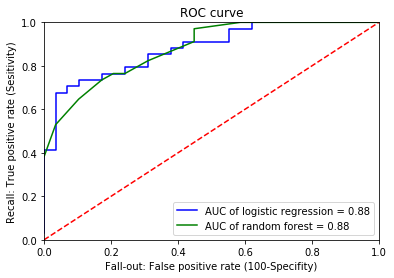

In [68]:
false_positive_rate_logreg, recall_logreg, thresholds_logreg = roc_curve(y_true_logreg,
y_pred_logreg)
roc_auc_logreg = auc(false_positive_rate_logreg, recall_logreg)

false_positive_rate_ranfor, recall_ranfor, thresholds_ranfor = roc_curve(y_true_ranfor,
y_pred_ranfor)
roc_auc_ranfor = auc(false_positive_rate_ranfor, recall_ranfor)


plt.title('ROC curve')
plt.plot(false_positive_rate_logreg, recall_logreg, 'b', label='AUC of logistic regression = %0.2f' %
roc_auc_logreg)
plt.plot(false_positive_rate_ranfor, recall_ranfor, 'g', label='AUC of random forest = %0.2f' %
roc_auc_ranfor)

plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.ylabel('Recall: True positive rate (Sesitivity)')
plt.xlabel('Fall-out: False positive rate (100-Specifity)')
plt.show()

The ROC curve of logistic ragression model is deeper at the beginning than that of random forest model. So, if we are looking for less false positive rate, logistic ragression model is a better choice; if we ar elooking for high detective rate, random forest model will be a better choice. 

Sice Kaggle punishs the prediction that something is true when it is actually false, the false positive prediction, so logistic ragression model is a better choice, under evaluation rule of Kaggle. (https://www.kaggle.com/c/womens-machine-learning-competition-2018#evaluation)

### Evaluation Summary

After checking Log Loss, Accuracy, Precision and recall, F1 measure, and ROC Curve, the two models have similiar accuracy and F1 score, but the Log Loss value from cross validation of logistic regression is bette than that of random forest and the ROC curve indicates a better false positive of the logistic ragression. What's more, logistic regression is conceptualy better than random forest. All in all, the logistic regression is a favourable model to choose. 

## Deployment

- This model is used to predict the winning percentage of the every possible 2016 matchups in the 2018 NCAA Tournament Women's. Once the tournament begins and we have the bracket frame, with the threshold of 50% winning probability, the model can help users predict the total bracket including the winner of the tournament.

- To extend the model, if rolling the date set years forward, users can also use this model to predict the winning probability of NCAA Tournament Women's of year 2019, 2020, so on and so forth. However, as time goes by, the effectiveness of the model may change by rules, environment, players, fundings, etc. So, adjusting the model accordingly, is necessary for the forture years prediction and coreponding support will be provided by be provided by the team for users.